In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import (
    KMeans,
    MiniBatchKMeans,
    DBSCAN,
    AgglomerativeClustering,
    SpectralClustering
)

from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer



In [27]:
df = pd.read_csv("Reviews_sample_balanced.csv")
df = df.dropna(subset=["Text"])

texts = df["Text"].values

TF-IDF vektorizacija teksta

In [28]:
tfidf = TfidfVectorizer(
   max_features=15000, stop_words="english", ngram_range=(1,2)
)

X_tfidf = tfidf.fit_transform(texts)

Redukcija dimenzionalnosti

In [38]:
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)
scaler = Normalizer() # Tekstualni klastering najbolje radi sa normalizovanim vektorima
X_reduced = scaler.fit_transform(X_reduced)
X_2d = TruncatedSVD(n_components=2, random_state=42).fit_transform(X_tfidf)
X_2d = scaler.fit_transform(X_2d)

ALGORITMI KLASTEROVANJA

K-Means Clustering

In [30]:
kmeans = KMeans(n_clusters=5, random_state=42)
labels_kmeans = kmeans.fit_predict(X_reduced)

sil_kmeans = silhouette_score(X_reduced, labels_kmeans)
print("KMeans Silhouette Score:", sil_kmeans)

unique, counts = np.unique(labels_kmeans, return_counts=True)
print("KMeans cluster sizes:", dict(zip(unique, counts)))

KMeans Silhouette Score: 0.050628385192503324
KMeans cluster sizes: {0: 1226, 1: 5530, 2: 919, 3: 662, 4: 1663}


In [39]:
kmeans_2d = KMeans(n_clusters=5, random_state=42)
labels_2d = kmeans_2d.fit_predict(X_2d)

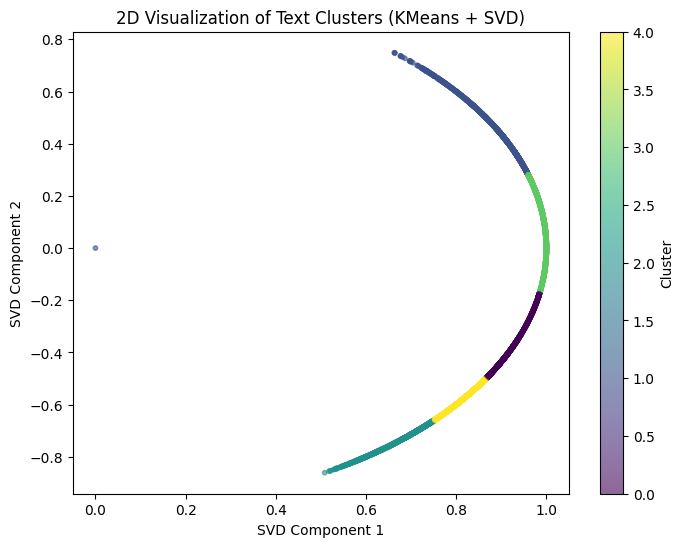

In [40]:
plt.figure(figsize=(8, 6))
plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=labels_2d,
    s=10,
    alpha=0.6
)

plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.title("2D Visualization of Text Clusters (KMeans + SVD)")
plt.colorbar(label="Cluster")
plt.show()

In [33]:
def get_top_keywords(data, clusters, vectorizer, n_terms=10):
    df_tmp = pd.DataFrame(data.toarray(), columns=vectorizer.get_feature_names_out())
    df_tmp['cluster'] = clusters
    words = df_tmp.groupby('cluster').mean()
    for i, r in words.iterrows():
        print(f"\nCluster {i}:")
        print(", ".join([words.columns[x] for x in np.argsort(r)[-n_terms:]]))

print("Top reči po klasterima za KMeans:")
get_top_keywords(X_tfidf, labels_kmeans, tfidf)

Top reči po klasterima za KMeans:

Cluster 0:
order, price, use, like, taste, buy, good, great, amazon, product

Cluster 1:
really, dog, love, flavor, food, great, good, just, taste, like

Cluster 2:
roast, strong, br, flavor, taste, good, like, cups, cup, coffee

Cluster 3:
good, drink, flavor, green tea, green, taste, like, teas, br, tea

Cluster 4:
great, flavor, good, taste, just, product, food, like, br br, br


MiniBatch K-Means

In [34]:
minibatch = MiniBatchKMeans(n_clusters=5, random_state=42, batch_size=1000)
labels_minibatch = minibatch.fit_predict(X_reduced)

sil_minibatch = silhouette_score(X_reduced, labels_minibatch)
print("MiniBatch KMeans Silhouette Score:", sil_minibatch)

unique, counts = np.unique(labels_minibatch, return_counts=True)
print("MiniBatch cluster sizes:", dict(zip(unique, counts)))


MiniBatch KMeans Silhouette Score: 0.04684757399495202
MiniBatch cluster sizes: {0: 1494, 1: 3554, 2: 1600, 3: 1254, 4: 2098}


DBSCAN

In [35]:
dbscan = DBSCAN(eps=0.2, min_samples=10, metric='cosine') 
labels_dbscan = dbscan.fit_predict(X_reduced)

n_clusters_db_ = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
if n_clusters_db_ > 1:
    sil_db = silhouette_score(X_reduced, labels_dbscan)
    print("DBSCAN Silhouette Score:", sil_db)


DBSCAN Silhouette Score: -0.08414119206309205


Agglomerative Clustering

In [36]:
agg = AgglomerativeClustering(n_clusters=5)
labels_agg = agg.fit_predict(X_reduced)

unique, counts = np.unique(labels_agg, return_counts=True)
print("Agglomerative cluster sizes:", dict(zip(unique, counts)))


Agglomerative cluster sizes: {0: 6757, 1: 876, 2: 875, 3: 880, 4: 612}


Spectral Clustering

In [37]:
sample_idx = np.random.choice(len(X_reduced), size=2000, replace=False)
X_sample = X_reduced[sample_idx]

spectral = SpectralClustering(
    n_clusters=5,
    random_state=42,
    affinity="nearest_neighbors"
)

labels_spectral = spectral.fit_predict(X_sample)

sil_spectral = silhouette_score(X_sample, labels_spectral)
print("Spectral Clustering Silhouette Score:", sil_spectral)

unique, counts = np.unique(labels_spectral, return_counts=True)
print("Spectral cluster sizes:", dict(zip(unique, counts)))


Spectral Clustering Silhouette Score: 0.018988709378246607
Spectral cluster sizes: {0: 1822, 1: 16, 2: 119, 3: 19, 4: 24}
